In [1]:
# in Colab, rasterio needs to be installed
# !pip install rasterio

import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch

# download and extract the dataset sample (I uploaded it to my GDrive)
if not pathlib.Path('../SEN12MS_sample').is_dir():
    !gdown --id 1GKHIPhhfjutCbb3LhJ0tgjxDvIuDO7tr
    !tar -zxf SEN12MS_sample.tgz
    !rm SEN12MS_sample.tgz
sys.path.insert(1,"../")
# this module comes with the dataset and it provides a data loader
import utils.sen12ms_dataLoader as sen12ms
sys.path.remove("../")

In [2]:
# initialize the data loader
dataset = sen12ms.SEN12MSDataset(base_dir='../SEN12MS_sample')

In [3]:
def get_false_color_s1_image(s1_data):
    """ Generate a VV/VH/R false color image to plot with matplotlib. """
    
    # add a polarization ratio channel
    image = np.empty(shape=(3,) + s1_data.shape[1:])  # new shape is (3, H, W)
    image[:2, ...] = s1_data                          # the first two channels are the same
    image[2] = s1_data[0] - s1_data[1]                # the data is in dB, so ratio becomes difference

    # normalize channel-wise and swap axes from CHW to HWC
    shifted = image - image.min(axis=(1, 2), keepdims=True)
    spread = image.max(axis=(1, 2), keepdims=True) - image.min(axis=(1, 2), keepdims=True)
    
    image = np.transpose(shifted / spread, [1, 2, 0])
    
    return image

In [36]:
# get data
season = sen12ms.Seasons.SUMMER
scene = next(iter(dataset.get_scene_ids(season)))
patch_ids = dataset.get_patch_ids(season, scene)

sample_patches = random.sample(patch_ids, 3)
# sample_patches = [591, 861, 185]
kwargs = {
    'season': season,
    'scene_ids': scene,
    'patch_ids': sample_patches,
    's1_bands': sen12ms.S1Bands.ALL,
    's2_bands': sen12ms.S2Bands.ALL,
    'lc_bands': sen12ms.LCBands.ALL,
}

s1, s2, lc, _ = dataset.get_triplets(**kwargs)


In [15]:
# ----------------------------------------
# load gray model
# ----------------------------------------
from models.network_unet import UNetRes as net

model_pool = 'model_zoo'             # fixed
model_name = 'drunet_gray'  # set denoiser model, 'drunet_gray' | 'drunet_color'
model_path = os.path.join(model_pool, model_name+'.pth')

n_channels = 1                       # 1 for grayscale image
if 'color' in model_name:
    n_channels = 3                   # 3 for color image
task_current = 'dn'                  # 'dn' for denoising

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

model_gray = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
try:
    model_gray.load_state_dict(torch.load(model_path), strict=True)
except:
    !mkdir "model_zoo"
    !gdown --id "12VJ7_OUqHCapTPorXrl_RXJBthUCyt9N" -O "model_zoo/"
    model_gray.load_state_dict(torch.load(model_path), strict=True)
    
model_gray.eval()
for k, v in model_gray.named_parameters():
    v.requires_grad = False
model_gray = model_gray.to(device)
print('Model path: {:s}'.format(model_path))
number_parameters = sum(map(lambda x: x.numel(), model_gray.parameters()))
print('Params number: {}'.format(number_parameters))


Model path: model_zoo/drunet_gray.pth
Params number: 32638656


In [6]:
# ----------------------------------------
# load RGB model
# ----------------------------------------
from models.network_unet import UNetRes as net

model_pool = 'model_zoo'             # fixed
model_name = 'drunet_color'  # set denoiser model, 'drunet_gray' | 'drunet_color'
model_path = os.path.join(model_pool, model_name+'.pth')

n_channels = 1                       # 1 for grayscale image
if 'color' in model_name:
    n_channels = 3                   # 3 for color image
task_current = 'dn'                  # 'dn' for denoising

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

model_rgb = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
try:
    model_rgb.load_state_dict(torch.load(model_path), strict=True)
except:
    !mkdir "model_zoo"
    !gdown --id "12VJ7_OUqHCapTPorXrl_RXJBthUCyt9N" -O "model_zoo/"
    model_rgb.load_state_dict(torch.load(model_path), strict=True)
    
model_rgb.eval()
for k, v in model_rgb.named_parameters():
    v.requires_grad = False
model_rgb = model_rgb.to(device)
print('Model path: {:s}'.format(model_path))
number_parameters = sum(map(lambda x: x.numel(), model_rgb.parameters()))
print('Params number: {}'.format(number_parameters))


Model path: model_zoo/drunet_color.pth
Params number: 32640960


In [7]:
def normalize(data):
    mean = data.mean()
    std = data.std()
    
    return (data - mean)/std, mean, std

def normalize_batch(data):
    mean = []
    std = []
    for i in range(len(data)):
        d,m,s = normalize(data[i,0])
        data[i,0] = d
        mean.append(m)
        std.append(s)
        
    return data, mean, std
        
def denormalize(data, mean, std, shift=1):
    return (data*std)+mean

def denormalize_batch(data, mean, std):
    for i in range(len(data)):
        data[i,0] = denormalize(data[i,0],mean[i],std[i])
    return data



In [8]:
def scale(data):
    min_ = data.min()
    max_ = data.max()
    return (data - min_) / (max_ - min_+1e-8),min_,max_

def scale_batch(data):
    mins = []
    maxs = []
    for i in range(len(data)):
        d,min_,max_ = scale(data[i,0])
        data[i,0] = d
        mins.append(min_)
        maxs.append(max_)
        
    return data, mins, maxs
        
def descale(data, min_, max_, ):
    return min_+ data * (max_ - min_+1e-8)

def descale_batch(data, mins, maxs):
    for i in range(len(data)):
        data[i,0] = descale(data[i,0],mins[i],maxs[i])
    return data


In [37]:
# fPrepare data gray

noise_level_model = 70.

print(f's1.shape: {s1.shape}\n')

# Santinel-1
din = torch.tensor(s1, device = device, dtype = torch.float32)

din = din.reshape([din.shape[0]*2,1,din.shape[2],din.shape[3]])

din, mean, std = scale_batch(din)

# add random normal noise
din += torch.randn(din.shape,device=device,dtype = torch.float32)*noise_level_model/255.
# Add noise map
nose_map = torch.tensor([noise_level_model/255.],device=device, dtype = torch.float32).repeat(din.shape[0], 1, din.shape[2], din.shape[3])
din_gray = torch.cat((din,nose_map), dim=1)


print(f'din_gray.shape: {din_gray.shape}\n')
# mono  din.shape: torch.Size([bs, 2, 256, 256])
# color din.shape: torch.Size([bs, 4, 256, 256])

# fPrepare data RGB

noise_level_model = 70.

# print(f's1.shape: {s1.shape}\n')
# print(f's2.shape: {s2.shape}\n')
# print(f'lc.shape: {lc.shape}\n')

# Santinel-1
din = torch.tensor([get_false_color_s1_image(img) for img in s1],device=device, dtype = torch.float32)
din = din.permute([0,3,1,2])
# add random normal noise
din += torch.randn(din.shape,device=device,dtype = torch.float32)*noise_level_model/255.
# Add noise map
nose_map = torch.tensor([noise_level_model/255.],device=device, dtype = torch.float32).repeat(din.shape[0], 1, din.shape[2], din.shape[3])
din_rgb = torch.cat((din,nose_map), dim=1)


print(f'din_rgb.shape: {din_rgb.shape}\n')
# mono  din.shape: torch.Size([bs, 2, 256, 256])
# color din.shape: torch.Size([bs, 4, 256, 256])



s1.shape: (3, 2, 256, 256)

din_gray.shape: torch.Size([6, 2, 256, 256])

din_rgb.shape: torch.Size([3, 4, 256, 256])



In [38]:
# denoze RGB img
denoised_rgb = model_rgb(din_rgb)
denoised_rgb = denoised_rgb.to('cpu').permute([0,2,3,1]).numpy()
denoised_rgb.shape

(3, 256, 256, 3)

In [39]:
# denoze gray img
denoised_gray = model_gray(din_gray)
denoised_gray = descale_batch(denoised_gray, mean, std)
denoised_gray = denoised_gray.reshape([int(denoised_gray.shape[0]/2),2,denoised_gray.shape[2],denoised_gray.shape[3]]).to('cpu').numpy()
denoised_gray.shape



(3, 2, 256, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Denoised Sentinel-1 in rgb')

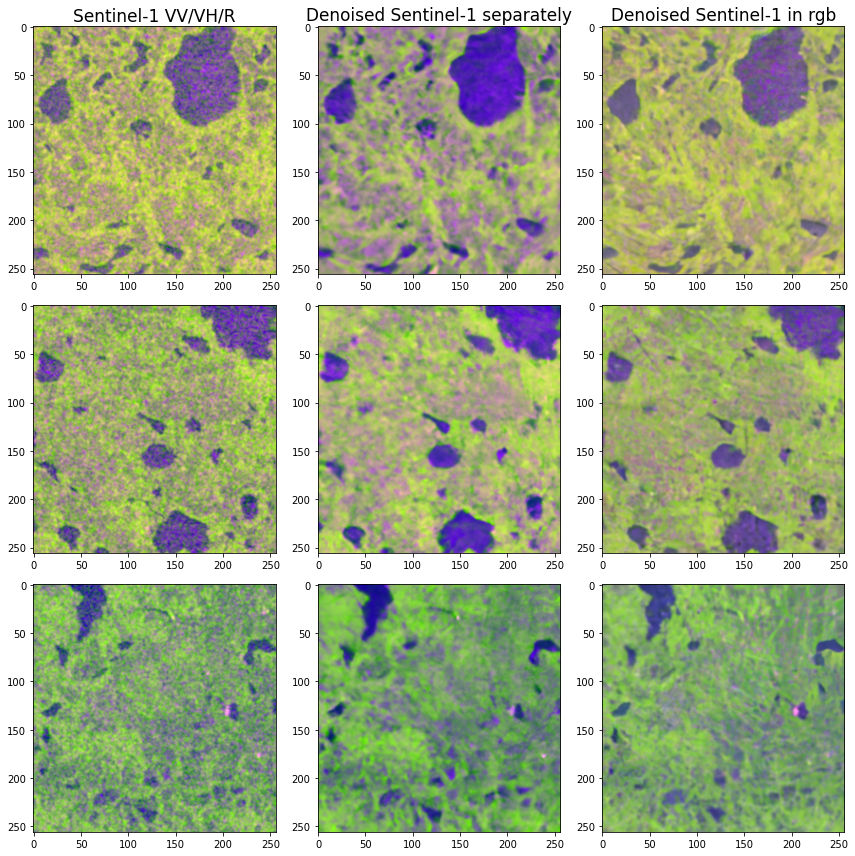

In [40]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), tight_layout=True)
for i in range(3):
    s1_image = get_false_color_s1_image(s1[i])
    denoised_gray_image = get_false_color_s1_image(denoised_gray[i])
    denoised_rgb_image = denoised_rgb[i]
    
    axes[i, 0].imshow(s1_image, aspect='auto', cmap='binary')
    axes[i, 1].imshow(denoised_gray_image, aspect='auto', cmap='binary')
    axes[i, 2].imshow(denoised_rgb_image, aspect='auto')
#     axes[i, 2].imshow(lc_image.squeeze(), aspect='auto')

axes[0, 0].set_title('Sentinel-1 VV/VH/R', fontsize=17)
axes[0, 1].set_title('Denoised Sentinel-1 separately', fontsize=17);
axes[0, 2].set_title('Denoised Sentinel-1 in rgb', fontsize=17)
# axes[0, 2].set_title('Land cover (disapointing)', fontsize=17)

